In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import ase
import ase.io
from ase.visualize import view

In [2]:
input_file = 'me-rigid-shortaug3-gscc.xyz'
energy = "energy"
frames = ase.io.read(input_file,":")
energies = np.array([cc.info[energy] for cc in frames[:100]])

In [3]:
frames[0].get_all_distances()

array([[0.        , 1.08814377, 1.08800326, 1.08800193, 1.08811616,
        4.70320931, 5.43436821, 4.06440486, 4.28393093, 5.36770046],
       [1.08814377, 0.        , 1.77649564, 1.77651711, 1.77691627,
        3.70468279, 4.37772004, 3.11946921, 3.28993702, 4.46261608],
       [1.08800326, 1.77649564, 0.        , 1.77694096, 1.77697233,
        4.83972331, 5.67589402, 4.0920397 , 4.58040323, 5.33727068],
       [1.08800193, 1.77651711, 1.77694096, 0.        , 1.77698604,
        5.41222747, 6.01097761, 4.69971652, 5.05589973, 6.17435446],
       [1.08811616, 1.77691627, 1.77697233, 1.77698604, 0.        ,
        5.17364266, 5.94482894, 4.71607217, 4.5573349 , 5.78358821],
       [4.70320931, 3.70468279, 4.83972331, 5.41222747, 5.17364266,
        0.        , 1.08812518, 1.08815328, 1.08816171, 1.08810723],
       [5.43436821, 4.37772004, 5.67589402, 6.01097761, 5.94482894,
        1.08812518, 0.        , 1.77692718, 1.77691601, 1.77690041],
       [4.06440486, 3.11946921, 4.0920397

In [4]:
CC_distances = []
CH_distances = []
HH_distances = []
CH_intra_distances = []
CH_inter_distances = []
HH_intra_distances = []
HH_inter_distances = []
for frame in frames[:100]:
    distances = frame.get_all_distances()
    CC_distances.append(distances[5][0])
    
    CH_intra_distances.append(distances[0][1])
    CH_inter_distances.append(distances[0][6])
    HH_intra_distances.append(distances[1][2])
    HH_inter_distances.append(distances[1][6])
    
    CH_distances.append(distances[0][6])
    CH_distances.append(distances[0][7])
    CH_distances.append(distances[0][8])
    CH_distances.append(distances[0][9])
    CH_distances.append(distances[5][1])
    CH_distances.append(distances[5][2])
    CH_distances.append(distances[5][3])
    CH_distances.append(distances[5][4])
    
    HH_distances.append(distances[1][6])
    HH_distances.append(distances[1][7])
    HH_distances.append(distances[1][8])
    HH_distances.append(distances[1][9])
    HH_distances.append(distances[2][6])
    HH_distances.append(distances[2][7])
    HH_distances.append(distances[2][8])
    HH_distances.append(distances[2][9])
    HH_distances.append(distances[3][6])
    HH_distances.append(distances[3][7])
    HH_distances.append(distances[3][8])
    HH_distances.append(distances[3][9])
    HH_distances.append(distances[4][6])
    HH_distances.append(distances[4][7])
    HH_distances.append(distances[4][8])
    HH_distances.append(distances[4][9])

In [5]:
def radial_basis_function(delta,x, x_j, theta):
    "Calculate Gaussian kernel"
    return delta*np.exp(-((x-x_j)**2)/theta**2)

In [6]:
def k_NM_builder(CC_k_MM, CH_k_MM, HH_k_MM):
    "Build a NM kernel matrix for any data set from the k_MM matrix"
    k_NM = np.zeros((100,2500))
    for i in range(100):
        CC_row = CC_k_MM[i]
        CH_row = CH_k_MM[8*i:8*(i+1)]
        HH_row = HH_k_MM[16*i:16*(i+1)]
        row = np.concatenate((CC_row, CH_row.sum(axis = 0), HH_row.sum(axis = 0)))
        k_NM[i] = row
    return k_NM

In [7]:
def k_MM_builder(distances, delta):
    "Build a MM kernel matrix for any data set"
    kernel = []
    for i in distances:
        k = []
        for j in distances:
            k.append(radial_basis_function(delta,i,j,1))
        kernel.append(k)
    kernel = np.asarray(kernel)
    return kernel

In [8]:
CC_k_MM = k_MM_builder(CC_distances, 10)
CH_k_MM = k_MM_builder(CH_distances, 1)
HH_k_MM = k_MM_builder(HH_distances, 1)
print(CC_k_MM.shape, CH_k_MM.shape, HH_k_MM.shape)

(100, 100) (800, 800) (1600, 1600)


In [9]:
k_MM = np.block([[CC_k_MM,np.zeros((len(CC_k_MM),len(CH_k_MM))) ,np.zeros((len(CC_k_MM),len(HH_k_MM))) ],
                 [np.zeros((len(CH_k_MM),len(CC_k_MM))), CH_k_MM,np.zeros((len(CH_k_MM),len(HH_k_MM)))],
                 [np.zeros((len(HH_k_MM),len(CC_k_MM))),np.zeros((len(HH_k_MM),len(CH_k_MM))) , HH_k_MM]])
k_NM = k_NM_builder(CC_k_MM, CH_k_MM, HH_k_MM)
print(k_MM.shape, k_NM.shape)

(2500, 2500) (100, 2500)


In [10]:
print(k_MM)

[[10.          0.12851964  9.95364106 ...  0.          0.
   0.        ]
 [ 0.12851964 10.          0.17002054 ...  0.          0.
   0.        ]
 [ 9.95364106  0.17002054 10.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.          0.58682437
   0.70248744]
 [ 0.          0.          0.         ...  0.58682437  1.
   0.98171582]
 [ 0.          0.          0.         ...  0.70248744  0.98171582
   1.        ]]


In [11]:
def kernel_regression(energies, k_MM, k_NM, sigma):
    N = len(energies)
    alpha = np.linalg.lstsq(k_MM + np.transpose(k_NM).dot(np.linalg.inv(np.eye(N)*sigma**2)).dot(k_NM), np.transpose(k_NM).dot(np.linalg.inv(np.eye(N)*sigma**2)).dot(np.transpose(energies)))[0]
    return alpha

In [12]:
sigma = 1
np.linalg.matrix_rank(np.transpose(k_NM).dot(np.linalg.inv(np.eye(len(energies))*sigma**2)).dot(k_NM))

47

In [13]:
np.linalg.matrix_rank(k_MM)

87

In [14]:
sigma = 1
print(np.linalg.cond(CC_k_MM + sigma**2*np.eye(len(CC_k_MM[0]))))
print(np.linalg.cond(CH_k_MM + sigma**2*np.eye(len(CH_k_MM[0]))))
print(np.linalg.cond(HH_k_MM + sigma**2*np.eye(len(HH_k_MM[0]))))

414.34512453807855
297.75396658976086
554.4313199750887


In [15]:
print(np.linalg.cond(k_MM + sigma**2*np.eye(len(k_MM[0]))))

554.4313199750887


In [16]:
alpha = kernel_regression(energies, k_MM, k_NM, sigma)

C:\Users\sahil\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
def energy_fit(k_NM, alpha):
    "Return the kernel fit of the energies"
    return k_NM.dot(alpha)

In [18]:
fitted_energies = energy_fit(k_NM, alpha)

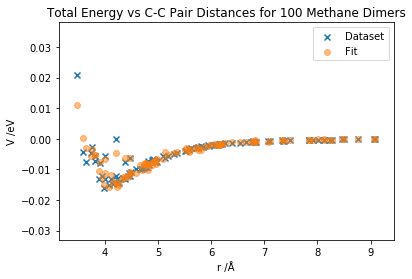

In [19]:
plt.scatter(CC_distances, energies, marker = "x", label="Dataset")
plt.scatter(CC_distances, fitted_energies, linestyle = "-", label="Fit", alpha=0.5)
plt.xlabel("r /Å")
plt.ylabel("V /eV")
plt.title("Total Energy vs C-C Pair Distances for 100 Methane Dimers")
plt.legend()
plt.show()

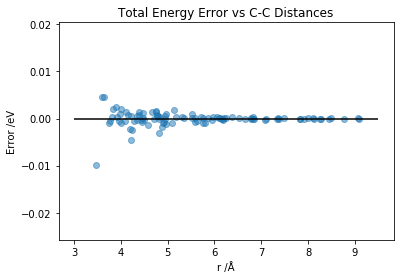

In [20]:
plt.scatter(CC_distances, fitted_energies-energies, alpha=0.5)
plt.hlines(0, 3,9.5)
plt.xlabel("r /Å")
plt.ylabel("Error /eV")
plt.title("Total Energy Error vs C-C Distances")
plt.show()

In [21]:
np.sqrt(np.mean((fitted_energies-energies)**2))/2

0.0007584375744440012